# Expensiveness classification (binary classification)

The problem scope defines a product as expensive if the product price is above the percentile 85. We predict 1 (True) if product is expensive, 0 (False) if not.

$Price_p > Percentile(80)$

Naturally, this creates an imbalanced issue on the dataset, since there will be 85% of the data classified as 0.

In [1]:
import pandas as pd
from sqlalchemy import create_engine
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
#import joblib

from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics import make_scorer, RocCurveDisplay
import json

import os
from skopt import BayesSearchCV
from skopt.space import Real

#from imblearn.metrics import specificity_score
import matplotlib.pyplot as plt
import numpy as np 

def load_credentials(path = "aws_rds_credentials.json"):
     with open(path, 'r') as file:
          config = json.load(file)

     # set up credentials
     for key in config.keys():
          os.environ[key] = config[key]

     return

time_interval = 90 #days

load_credentials()

aws_rds_url = f"postgresql://{os.environ['user']}:{os.environ['password']}@{os.environ['host']}:{os.environ['port']}/{os.environ['database']}?sslmode=require"

engine = create_engine(aws_rds_url)
sql_query = f"""SELECT catalog_id, price_numeric, size_title, brand_title, country, color1, status
               FROM public.tracking_staging 
               WHERE date >= CURRENT_DATE - INTERVAL '{time_interval} days'
               LIMIT 10000
               """
data = pd.read_sql(sql_query, engine)
data.head(10)

,catalog_id,price_numeric,size_title,brand_title,country,color1,status
0,264,17,M,Uniqlo,França,Cinzento,Muito bom
1,1204,50,14 anos / 164 cm,Emporio Armani,Italie,Preto,Muito bom
2,1663,25,12 anos / 152 cm,Fred Perry,Italie,Cinzento,Muito bom
3,267,25,S,Thrasher,Italie,Cinzento,Bom
4,1846,10,XS / 34 / 6,Zara,Italie,Preto,Muito bom
5,1041,6,S / 36 / 8,Zara Trafaluc,Italie,Bordeaux,Muito bom
6,1041,5,S / 36 / 8,Zara,Italie,Branco,Muito bom
7,221,5,S / 36 / 8,Bershka,Italie,Branco,Muito bom
8,1065,15,XS / 34 / 6,Molly Bracken,Italie,Branco,Muito bom
9,1065,4,XS / 34 / 6,H&M Divided,Italie,Preto,Muito bom


## The dataset

| Field        | Description                                            |
|--------------|--------------------------------------------------------|
| catalog_id   | Unique identifier for items in the catalog or database.|
| price_numeric| Price of each item stored in numerical format.         |
| size_title   | Information about the size or dimensions of the items. |
| brand_title  | Brand or manufacturer of each item.                    |
| status  | Qaulity status of the item.                    |
| color  | Color of the item.                    |
| color  | Country origin of the seller.                   |

Price numeric doesn't account any discounts from the seller side nor additional fees incurred from the buyer side.

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   catalog_id     10000 non-null  int64 
 1   price_numeric  10000 non-null  int64 
 2   size_title     10000 non-null  object
 3   brand_title    10000 non-null  object
 4   country        10000 non-null  object
 5   color1         8695 non-null   object
 6   status         10000 non-null  object
dtypes: int64(2), object(5)
memory usage: 547.0+ KB


In [3]:
# filling color 
data["color1"] = data["color1"].fillna("no_color")

## Preprocessing

- remove outliers
- define target variable and labels
- label encode labels

The first assumption of this model is that some sellers misprice their items. For that reason, we are considering some items are price under or above their fair value. Removing such samples should improve the model performance in real data.

### One Class SVM for novelty detection

One-Class SVMs learn a representation of the "normal" data distribution and classify instances outside this representation as anomalies. This characteristic makes them particularly suitable for scenarios where anomalies are rare or poorly represented in the training data. We employ the radial basis function (RBF) kernel due to its ability to capture complex relationships in nonlinear data.

In [4]:
from sklearn import svm

clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(data["price_numeric"].values.reshape(-1, 1))
y_pred_train = clf.predict(data["price_numeric"].values.reshape(-1, 1))
data["svm"] = y_pred_train
data = data[data["svm"] == 1]

## Target variable

In [5]:
threshold = 0.80
data["target"] = data["price_numeric"].apply(lambda x: 1 if x > data["price_numeric"].quantile(threshold) else 0)

## Dealing with class imbalance

The method used to deal with class imbalance is through undersampling because we have more than enough data to train the model, otherwise we might have to choose oversampling.

This approach aims to balance the class distribution by randomly selecting a subset of instances from the majority class, equalizing the number of instances between the majority and minority classes. Undersampling can be an effective strategy when the dataset is sufficiently large and removing instances from the majority class does not significantly impact the representativeness of the data.

In [6]:
# data balancing
def stratified_sampling(group):
    return group.sample(min(len(group), target_sample_size), replace=False)

# Calculate the target sample size (assuming equal sizes for both classes)
target_sample_size = data['target'].value_counts().min()

# Apply the stratified sampling using groupby and apply
data = data.groupby('target', group_keys=False).apply(stratified_sampling)
data.describe(include=object)

,size_title,brand_title,country,color1,status
count,2830,2830,2830,2830,2830
unique,123,907,28,29,5
top,,,France,Preto,Muito bom
freq,567,450,1301,681,1577


## Encoding categorical features

The choice of encoding of the feature space is:
- Ordinal Encoding for status because it's a feature with a natural ranking. Suitable for ordinal categorical variables where there is a clear order or ranking among the categories.
- OneHot Encoding for catalog_id, size_title and brand_title into a sparse binary matrix. Creates a binary (0/1) indicator variable for each category in the original variable. It prevents the model from assuming an ordinal relationship between categories.

In [7]:
# data transformation prior to training
ordinal_encoder = OrdinalEncoder(categories=[["Satisfatório", "Bom", "Muito bom", "Novo sem etiquetas", "Novo com etiquetas"]])
status = pd.DataFrame(ordinal_encoder
                        .fit_transform(data[['status']])
                        ).add_prefix("status_")
                        
status_decoded = ordinal_encoder.get_feature_names_out(input_features= ["status"])

catalog_onehot_encoder = OneHotEncoder(sparse_output=False)
catalog_id = pd.DataFrame(catalog_onehot_encoder
                            .fit_transform(data[['catalog_id']])
                            ).add_prefix("catalog_id_")

catalog_id_decoded = catalog_onehot_encoder.get_feature_names_out(input_features= ["catalog_id"])

size_onehot_encoder = OneHotEncoder(sparse_output=False)
size_title = pd.DataFrame(size_onehot_encoder
                            .fit_transform(data[['size_title']])
                            ).add_prefix("size_title_")

size_decoded = size_onehot_encoder.get_feature_names_out(input_features= ["size_title"])

brand_onehot_encoder = OneHotEncoder(sparse_output=False)
brand_title = pd.DataFrame(brand_onehot_encoder
                            .fit_transform(data[['brand_title']])
                            ).add_prefix("brand_title_")

brand_decoded = brand_onehot_encoder.get_feature_names_out(input_features= ["brand_title"])

color1_onehot_encoder = OneHotEncoder(sparse_output=False)
color1 = pd.DataFrame(color1_onehot_encoder
                            .fit_transform(data[['color1']])
                            ).add_prefix("color1_")

color1_decoded = color1_onehot_encoder.get_feature_names_out(input_features= ["color1"])

labels = pd.concat([size_title, status, brand_title, catalog_id, color1], axis=1, ignore_index=False)
cols = size_decoded.tolist() + status_decoded.tolist() + brand_decoded.tolist() + color1_decoded.tolist()

model_params = pd.DataFrame([labels.columns, cols]).T
model_params.columns = ["Labels", "Decoded"]
len(model_params)

1584

## Model training

Training a logistic regression model with hyperparameter tuning using BayesSearchCV. The saga solver is around n_iters*f(n)**n_features and accepts both "l1", "l2" regularization. The training was done by using the training set to find the optimal "C" param and then cross_validation on the training data to optimize the feature weights hyperparams. The classifier is a simple logit regression taking the feature space described above as input vector.

### Logistic regression

Logistic regression is a popular statistical method used for binary classification tasks, where the goal is to predict the probability that an instance belongs to a particular class.

$\sigma(z) = \frac{1}{1 + e^{-z}}$

and 

$z = w_0 + w_1x_1 + w_2x_2 + \ldots + w_nx_n$

The decision boundary is p=0.5p=0.5 (standard).

### Bayes Optimization
A balance between exploration and exploitation

Bayesian optimization employs a probabilistic surrogate model to approximate the objective function. Gaussian processes (GP) are commonly used as surrogate models due to their ability to capture uncertainty and model complex functions. It's popular to find (local) in expensive-to-evaluate functions using heurisitics based on bayes theorem.

#### Acquisition function

The acquisition function guides the search process by balancing exploration (sampling from uncertain regions) and exploitation (sampling from regions likely to contain the optimum). Common acquisition functions include:

- Expected Improvement (EI): Measures the expected improvement over the current best value.
- Upper Confidence Bound (UCB): Balances exploration and exploitation using confidence intervals.
- Probability of Improvement (PI): Measures the probability of improvement over the current best value.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(labels, data["target"], random_state=42)

# complexity nf(n)**n_features
lr = LogisticRegression(max_iter=1000, 
                        solver = 'saga')

# parameter space
parameters = {'C': Real(1e-1, 1e+1, 
                        prior='log-uniform')}

# Specify scoring metrics
# main scoring param has to be defined as "score" since scikit is fetching "mean_test_score"
scoring = {
        "score" : "roc_auc",
        "recall" : "recall",
        "accuracy" : "accuracy",
}

# Perform hyperparameter tuning with BayesSearchCV over 10 folds with AUC as refit metric.
gs_lr = BayesSearchCV(lr, 
                      parameters, 
                      cv=10, 
                      scoring=scoring, 
                      refit="score", 
                      n_iter=10, 
                      return_train_score=True)

# We need to fit the BayesSearchCV object to the train data in order to make predictions with the best model later
gs_lr.fit(X_train, y_train)

### Cross validation

The basic idea behind cross-validation is to partition the dataset into multiple subsets, called folds, and iteratively train and evaluate the model on different combinations of these folds. It's basically a bootstrapping of model errors on chunks of the dataset.


We take the average results as a better and more consistent estimation of model performance. By averaging performance metrics over multiple folds, cross-validation provides a more reliable estimate of how well the model generalizes to new, unseen data. In alternative, we can identify the one that achieves the best average performance across multiple folds and chose it as the leading model.
Lastly, which is not the case here, cross validation helps to assess the stability of model performance and learning across different subsets of the data

In [ ]:
# Run nested cross-validation over 10 folds
lr_scores = cross_validate(gs_lr,
                        X_test, 
                        y_test, 
                        cv=10, 
                        n_jobs= 1, 
                        verbose=0,
                        return_train_score=True, 
                        scoring=scoring)

lr_scores

In [ ]:
# Make cross-validated predictions 
lr_preds = cross_val_predict(lr, X_test, y_test, cv=10, n_jobs=-1)

In [ ]:
for score in lr_scores:
        print(f"{score:<17}: {np.mean(lr_scores[score]):.2f}")

best_lr_model = gs_lr.best_estimator_
print(f"Best model: {best_lr_model}")
#print(len(best_lr_model.coef_[0]))

fit_time         : 34.92
score_time       : 0.02
test_score       : 0.73
train_score      : 0.96
test_recall      : 0.66
train_recall     : 0.90
test_accuracy    : 0.68
train_accuracy   : 0.90
Best model: LogisticRegression(C=1.817975922826725, max_iter=1000, solver='saga')
1319


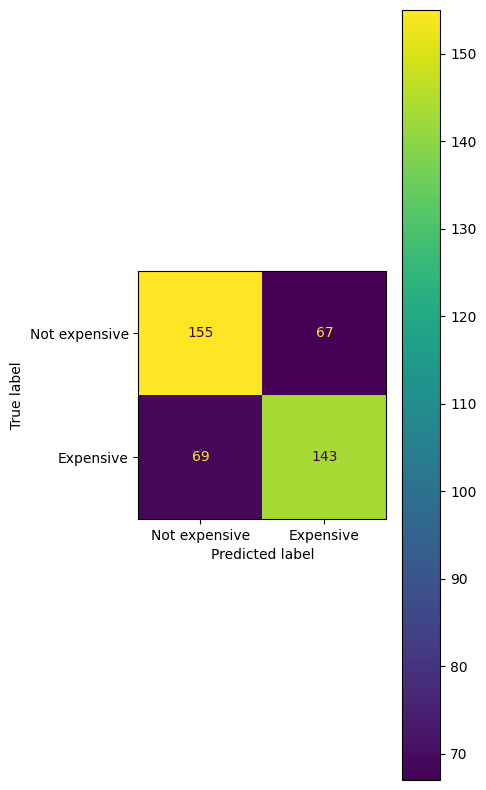

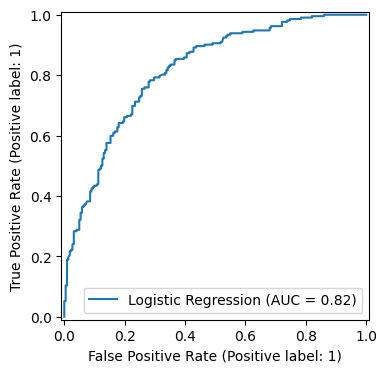

In [ ]:
f, axs = plt.subplots(1, 1, figsize=(4, 10))
disp = ConfusionMatrixDisplay.from_predictions(y_test, lr_preds,
                                        display_labels=['Not expensive', 'Expensive'],
                                        normalize=None,
                                        ax=axs)

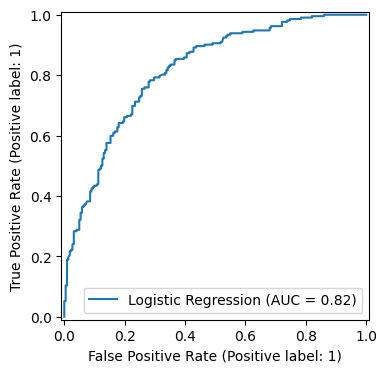

In [ ]:
f, axs = plt.subplots(1, 1, figsize=(5, 4))
roc = RocCurveDisplay.from_estimator(gs_lr.best_estimator_, X_test, y_test, 
                               name="Logistic Regression",
                               ax=axs)